In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import catboost
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../../data/'
X_train = pd.read_csv(f'{DATA_PATH}X_train.csv',sep='\t', index_col='index')
X_test = pd.read_csv(f'{DATA_PATH}X_test.csv', sep='\t', index_col='index')
y_train = pd.read_csv(f'{DATA_PATH}y_train.csv',sep='\t', index_col='index')
y_test = pd.read_csv(f'{DATA_PATH}y_test.csv',sep='\t', index_col='index')

In [3]:
X_train.head()

,t вып-обр,ПСН гр.,чист расход C,чист расход Si,температура первая,эл. энергия (интенс.),сыпуч известь РП,сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,химсталь первый C_1,...,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO
index,,,,,,,,,,,,,,,,,,,,,
589,0.188889,0.160236,0.460637,0.146587,0.52500,0.180650,0.206309,0.443063,0.637610,0.615385,...,0.050000,0.647287,0.007634,0.390879,0.045570,0.270270,0.678571,0.318182,0.180685,0.035461
1345,0.277778,0.291203,0.548485,0.323629,0.45000,0.214452,0.266774,0.511068,0.152566,0.495908,...,0.266667,0.457364,0.022901,0.426710,0.035443,0.243243,0.535714,0.090909,0.426791,0.070922
1663,0.122222,0.276659,0.550744,0.273617,0.26875,0.188005,0.185497,0.525138,0.202743,0.495908,...,0.241667,0.554264,0.049618,0.293160,0.037975,0.270270,0.566964,0.227273,0.227414,0.070922
1665,0.244444,0.118239,0.414093,0.180581,0.22500,0.178481,0.147987,0.393818,0.269645,0.608838,...,0.150000,0.589147,0.015267,0.201954,0.027848,0.513514,0.321429,0.045455,0.130841,0.042553
1666,0.222222,0.118239,0.205695,0.128265,0.23125,0.176531,0.131911,0.176906,0.409026,0.801964,...,0.183333,0.763566,0.007634,0.247557,0.020253,0.432432,0.531250,0.090909,0.168224,0.063830


In [40]:
target_columns = y_train.columns

In [5]:
future_columns = [column for column in X_train.columns if 'последний' in column]

y_train[future_columns] = X_train[future_columns]
X_train = X_train.drop(columns=future_columns)
y_test[future_columns] = X_test[future_columns]
X_test = X_test.drop(columns=future_columns)

In [6]:
future_columns

['химсталь последний C',
 'химсталь последний Ca',
 'химсталь последний Mn',
 'химсталь последний N',
 'химсталь последний S',
 'химсталь последний V',
 'химшлак последний FeO',
 'химшлак последний MgO',
 'химшлак последний MnO']

In [7]:
def fill_future_columns(X_train, X_test, y_train, y_test, future_column):
    future_column_list = future_column.copy()
    while len(future_column_list) != 0:
        prediction_result = {}
        for column in future_column_list:
            cur_eval_data = catboost.Pool(X_test, y_test[column])
            cur_model = catboost.CatBoostRegressor(iterations=1000,
                                learning_rate=0.05,
                                task_type='GPU',
                                loss_function='MAE',
                                random_seed= 42)
            cur_model.fit(X_train, y_train[column],
                          use_best_model=True,
                          early_stopping_rounds=100,
                          eval_set=cur_eval_data,
                          silent=True)
            prediction_result[column] = [cur_model.copy(), r2_score(
                y_pred=cur_model.predict(X_test), y_true=y_test[column])]
        best_r2 = -20
        best_target = ''
        for key in prediction_result.keys():
            if prediction_result[key][1] > best_r2:
                best_r2 = prediction_result[key][1]
                best_target = key
        if prediction_result[best_target][1] > 0.7:
            print(f'for column {best_target}: {best_r2}')
            X_train[best_target] = prediction_result[best_target][0].predict(X_train)
            X_test[best_target] = prediction_result[best_target][0].predict(X_test)
        else:
            break
        future_column_list.remove(best_target)
    return X_train, X_test

In [8]:
X_train, X_test = fill_future_columns(X_train, X_test, y_train, y_test, future_columns)

In [9]:
y_train = y_train.drop(columns=future_columns)
y_test = y_test.drop(columns=future_columns)


In [10]:
models = {}
for target in target_columns:
    eval_data = catboost.Pool(X_test,y_test[target])
    model = catboost.CatBoostRegressor(iterations=10000,
                                learning_rate=0.002,
                                task_type='GPU',
                                loss_function='MAE',
                                random_seed= 42)
    model.fit(X_train, y_train[target],
              use_best_model=True,
              early_stopping_rounds=1000,
              eval_set=eval_data,
              silent=True
              )
    models[target] = model

In [16]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [41]:
target_columns = target_columns.to_list()

In [43]:
target_columns_list = target_columns.copy()
while len(target_columns_list) > 0:
    prediction_result = {}
    for column in target_columns_list:
        cur_eval_data = catboost.Pool(X_test, y_test[column])
        cur_model = catboost.CatBoostRegressor(iterations=5000,
                            learning_rate=0.05,
                            task_type='GPU',
                            loss_function='MAE',
                            random_seed= 42)
        cur_model.fit(X_train, y_train[column],
                      use_best_model=True,
                      early_stopping_rounds=100,
                      eval_set=cur_eval_data,
                      silent=True)
        prediction_result[column] = [cur_model.copy(), r2_score(
            y_pred=cur_model.predict(X_test), y_true=y_test[column])]
    best_r2 = -20
    best_target = ''
    for key in prediction_result.keys():
        if prediction_result[key][1] > best_r2:
            best_r2 = prediction_result[key][1]
            best_target = key

    print(f'for column {best_target}: {best_r2}')
    X_train[best_target] = prediction_result[best_target][0].predict(X_train)
    X_test[best_target] = prediction_result[best_target][0].predict(X_test)
    target_columns_list.remove(best_target)


for column химшлак последний Al2O3: 0.38508828434020526
for column химшлак последний R: 0.3089997343023271
for column химшлак последний CaO: 0.16534557032614694
for column химшлак последний SiO2: 0.058377314444795436


In [17]:
r2_scores = np.zeros(4)
mae_scores = np.zeros(4)
mape_scores = np.zeros(4)
mse_scores = np.zeros(4)
for itarget, target in enumerate(target_columns):
    r2_scores[itarget] = r2_score(y_true=y_test[target],
                                  y_pred=models[target].predict(X_test))
    mse_scores[itarget] = mean_squared_error(y_true=y_test[target],
                                             y_pred=models[target].predict(X_test))
    mape_scores[itarget] = MAPE(y_test[target],
                                models[target].predict(X_test))
    mae_scores[itarget] = mean_absolute_error(y_true=y_test[target],
                                              y_pred=models[target].predict(X_test))

In [18]:
scores = pd.DataFrame(index=target_columns, columns=['R2','MAE','MSE','MAPe'])

In [19]:
scores['R2'] = r2_scores
scores['MAE'] = mae_scores
scores['MSE'] = mse_scores
scores['MAPe'] = mape_scores

In [20]:
scores

,R2,MAE,MSE,MAPe
химшлак последний Al2O3,0.392930,0.492485,0.493797,10.827127
химшлак последний CaO,0.147397,2.624139,12.077715,4.834188
химшлак последний R,0.357402,0.141352,0.031896,5.952268
химшлак последний SiO2,0.108102,1.587261,4.143639,6.867886


In [28]:
y_test['химшлак последний SiO2'].values[::15]

array([22.9, 22.7, 19.6, 26.1, 25.8, 23.2, 26.2, 21.2, 23.4, 25.8, 23.2,
       26. , 21.8, 25.4, 25.4, 22.9, 21.3, 22. , 23.4, 24.4, 24.5, 22.9,
       25.8, 25.4, 22.5, 23.6, 24.6, 24.9, 22.4, 27.4, 26.8, 26.7, 24.1,
       20.2, 26.5, 24.9, 24.6, 19.4, 25.4, 20.7, 23.6, 26.5, 25.3, 25.5,
       25.5, 21.7, 25.4, 22.6, 20.6, 25.7, 22. , 22.4, 21.3, 24.5, 21.6,
       25.5, 26.2, 26.7, 20.5, 22. , 22.8, 23.2, 22.7, 25. , 25.4, 19.3,
       26.9, 24.9, 26. , 26. , 27. , 22.1, 25.9, 19.7, 26.4, 26.2, 21.8,
       26.1, 23.1, 22.3, 27.2, 25.4, 23.2, 22. , 21.7, 21.8, 26.3, 22.5,
       24.7, 25.2, 25. , 21.2, 23.4, 22.3, 20.1, 27.5, 24. ])

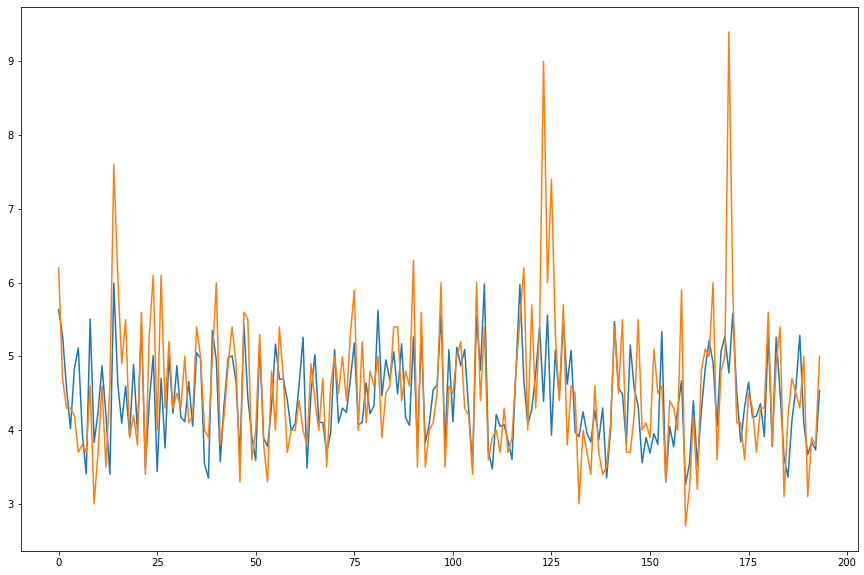

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(models['химшлак последний Al2O3'].predict(X_test)[::5])
plt.plot(y_test['химшлак последний Al2O3'].values[::5])
plt.show()